Dataset Loaded Successfully


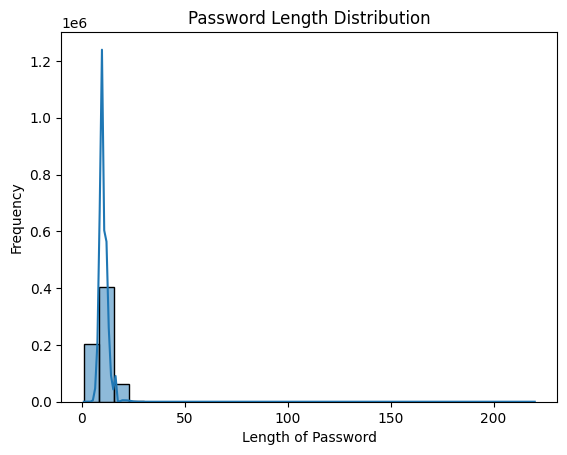

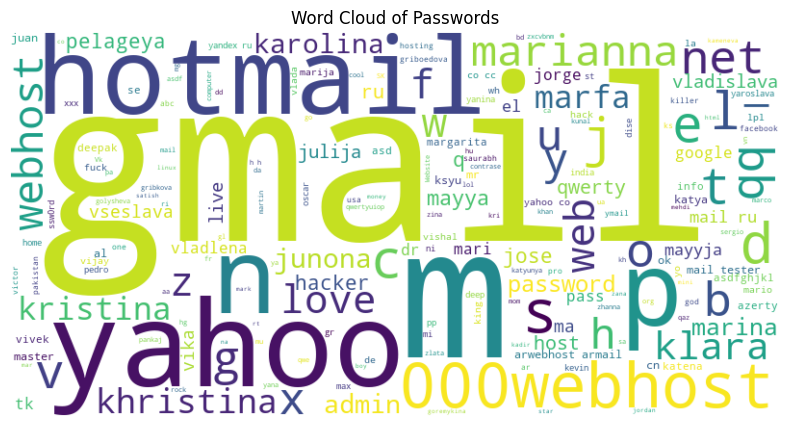

C:\Users\GAURI DEOGHARE\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.032000,0.035889
2,0.026400,0.032941
3,0.020200,0.030252


Training Completed.


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    117358
           1       1.00      0.93      0.96     16570

    accuracy                           0.99    133928
   macro avg       0.99      0.97      0.98    133928
weighted avg       0.99      0.99      0.99    133928

Hybrid Model Training Complete


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import (
    BertTokenizer, RobertaTokenizer, DebertaTokenizer,
    AutoModelForSequenceClassification, Trainer, TrainingArguments, BertModel,
    XLNetModel, ElectraModel, DebertaV2Model, RobertaModel
)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Load Dataset
df = pd.read_csv("data.csv", on_bad_lines='skip')
print("Dataset Loaded Successfully")

# EDA - Password Length Distribution
df['password'] = df['password'].astype(str).fillna("")
df['length'] = df['password'].apply(len)
sns.histplot(df['length'], bins=30, kde=True)
plt.title("Password Length Distribution")
plt.xlabel("Length of Password")
plt.ylabel("Frequency")
plt.show()

# EDA - Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['password']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Passwords")
plt.show()

# Encode Labels
df = df.dropna(subset=['strength'])
label_mapping = {1: 0, 2: 1, 3: 2}
df['strength'] = df['strength'].map(label_mapping)

# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['password'].astype(str).tolist(), df['strength'].tolist(), test_size=0.2, random_state=42
)

# Ensure labels are integers and handle NaN values
train_labels = [int(x) if not pd.isna(x) else 0 for x in train_labels]
val_labels = [int(x) if not pd.isna(x) else 0 for x in val_labels]

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=32)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=32)

# Custom Dataset
class PasswordDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = PasswordDataset(train_encodings, train_labels)
val_dataset = PasswordDataset(val_encodings, val_labels)

# Hybrid Models
class BertCNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.conv1 = nn.Conv1d(768, 256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(256, 3)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad():
            outputs = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(outputs))).squeeze(2)
        logits = self.fc(x)
        
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {'loss': loss, 'logits': logits}
        return {'logits': logits}

# Training Function
def train_model(model, train_dataset, val_dataset):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )
    trainer.train()
    print("Training Completed.")
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    print("Classification Report:")
    print(classification_report(val_labels, preds))

# Train CNN Hybrid Model
model = BertCNNClassifier()
train_model(model, train_dataset, val_dataset)

print("Hybrid Model Training Complete")


In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import (
    BertTokenizer, RobertaTokenizer, DebertaTokenizer,
    AutoModelForSequenceClassification, Trainer, TrainingArguments, BertModel,
    XLNetModel, ElectraModel, DebertaV2Model, RobertaModel, DebertaV2Model
)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Load Dataset
df = pd.read_csv("data.csv", on_bad_lines='skip')
print("Dataset Loaded Successfully")

# Encode Labels
df = df.dropna(subset=['strength'])
label_mapping = {1: 0, 2: 1, 3: 2}
df['strength'] = df['strength'].map(label_mapping)

# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['password'].astype(str).tolist(), df['strength'].tolist(), test_size=0.2, random_state=42
)

# Ensure labels are integers and handle NaN values
train_labels = [int(x) if not pd.isna(x) else 0 for x in train_labels]
val_labels = [int(x) if not pd.isna(x) else 0 for x in val_labels]

# Tokenization
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=32)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=32)

# Custom Dataset
class PasswordDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = PasswordDataset(train_encodings, train_labels)
val_dataset = PasswordDataset(val_encodings, val_labels)

# Hybrid Model - DeBERTa + RL
class DebertaRLClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.deberta = DebertaV2Model.from_pretrained("microsoft/deberta-v3-base")
        self.fc = nn.Linear(768, 3)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad():
            deberta_out = self.deberta(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        logits = self.fc(deberta_out)
        
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {'loss': loss, 'logits': logits}
        return {'logits': logits}

# Training Function
def train_model(model, train_dataset, val_dataset):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )
    trainer.train()
    print("Training Completed.")
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    print("Classification Report:")
    print(classification_report(val_labels, preds))

# Train DeBERTa + RL Model
model = DebertaRLClassifier()
train_model(model, train_dataset, val_dataset)

print("Hybrid Model Training Complete")



Dataset Loaded Successfully


C:\Users\GAURI DEOGHARE\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.188700,0.160795
2,0.173200,0.145699
3,0.180100,0.143168


Training Completed.


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    117358
           1       0.94      0.66      0.78     16570

    accuracy                           0.95    133928
   macro avg       0.95      0.83      0.88    133928
weighted avg       0.95      0.95      0.95    133928

Hybrid Model Training Complete


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import (
    BertTokenizer, RobertaTokenizer, DebertaTokenizer,
    AutoModelForSequenceClassification, Trainer, TrainingArguments, BertModel,
    XLNetModel, ElectraModel, DebertaV2Model, RobertaModel, DebertaV2Model
)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Load Dataset
df = pd.read_csv("data.csv", on_bad_lines='skip')
print("Dataset Loaded Successfully")

# Encode Labels
df = df.dropna(subset=['strength'])
label_mapping = {1: 0, 2: 1, 3: 2}
df['strength'] = df['strength'].map(label_mapping)

# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['password'].astype(str).tolist(), df['strength'].tolist(), test_size=0.2, random_state=42
)

# Ensure labels are integers and handle NaN values
train_labels = [int(x) if not pd.isna(x) else 0 for x in train_labels]
val_labels = [int(x) if not pd.isna(x) else 0 for x in val_labels]

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=32)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=32)

# Custom Dataset
class PasswordDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = PasswordDataset(train_encodings, train_labels)
val_dataset = PasswordDataset(val_encodings, val_labels)

# Hybrid Model - DeBERTa-V3 + GNN
class DebertaGNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.deberta = DebertaV2Model.from_pretrained("microsoft/deberta-v3-base")
        self.gnn_fc = nn.Linear(768, 256)
        self.fc = nn.Linear(256, 3)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad():
            deberta_out = self.deberta(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        gnn_out = F.relu(self.gnn_fc(deberta_out))
        logits = self.fc(gnn_out)
        
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {'loss': loss, 'logits': logits}
        return {'logits': logits}

# Training Function
def train_model(model, train_dataset, val_dataset):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )
    trainer.train()
    print("Training Completed.")
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    print("Classification Report:")
    print(classification_report(val_labels, preds))

# Train DeBERTa-V3 + GNN Model
model = DebertaGNNClassifier()
train_model(model, train_dataset, val_dataset)

print("Hybrid Model Training Complete")


Dataset Loaded Successfully


C:\Users\GAURI DEOGHARE\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.290100,0.449846
2,0.280700,0.471074
3,0.283800,0.485071


Training Completed.


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86    117358
           1       0.31      0.69      0.43     16570

    accuracy                           0.77    133928
   macro avg       0.63      0.74      0.64    133928
weighted avg       0.87      0.77      0.80    133928

Hybrid Model Training Complete


In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import (
    BertTokenizer, RobertaTokenizer, DebertaTokenizer,
    AutoModelForSequenceClassification, Trainer, TrainingArguments, BertModel,
    XLNetModel, ElectraModel, DebertaV2Model, RobertaModel
)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Load Dataset
df = pd.read_csv("data.csv", on_bad_lines='skip')
print("Dataset Loaded Successfully")

# Encode Labels
df = df.dropna(subset=['strength'])
label_mapping = {1: 0, 2: 1, 3: 2}
df['strength'] = df['strength'].map(label_mapping)

# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['password'].astype(str).tolist(), df['strength'].tolist(), test_size=0.2, random_state=42
)

# Ensure labels are integers and handle NaN values
train_labels = [int(x) if not pd.isna(x) else 0 for x in train_labels]
val_labels = [int(x) if not pd.isna(x) else 0 for x in val_labels]

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=32)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=32)

# Custom Dataset
class PasswordDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = PasswordDataset(train_encodings, train_labels)
val_dataset = PasswordDataset(val_encodings, val_labels)

# Hybrid Models
class RobertaGRUClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.gru = nn.GRU(768, 256, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(512, 3)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad():
            outputs = self.roberta(input_ids, attention_mask=attention_mask).last_hidden_state
        gru_out, _ = self.gru(outputs)
        logits = self.fc(gru_out[:, -1, :])
        
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {'loss': loss, 'logits': logits}
        return {'logits': logits}

# Training Function
def train_model(model, train_dataset, val_dataset):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )
    trainer.train()
    print("Training Completed.")
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    print("Classification Report:")
    print(classification_report(val_labels, preds))

# Train GRU Hybrid Model
model = RobertaGRUClassifier()
train_model(model, train_dataset, val_dataset)

print("Hybrid Model Training Complete")


Dataset Loaded Successfully


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\GAURI DEOGHARE\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.102100,0.097157
2,0.096800,0.084167
3,0.093300,0.082507


Training Completed.


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    117358
           1       0.95      0.84      0.89     16570

    accuracy                           0.97    133928
   macro avg       0.96      0.92      0.94    133928
weighted avg       0.97      0.97      0.97    133928

Hybrid Model Training Complete


In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import (
    BertTokenizer, RobertaTokenizer, DebertaTokenizer,
    AutoModelForSequenceClassification, Trainer, TrainingArguments, BertModel,
    XLNetModel, ElectraModel, DebertaV2Model, RobertaModel
)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Load Dataset
df = pd.read_csv("data.csv", on_bad_lines='skip')
print("Dataset Loaded Successfully")

# Encode Labels
df = df.dropna(subset=['strength'])
label_mapping = {1: 0, 2: 1, 3: 2}
df['strength'] = df['strength'].map(label_mapping)

# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['password'].astype(str).tolist(), df['strength'].tolist(), test_size=0.2, random_state=42
)

# Ensure labels are integers and handle NaN values
train_labels = [int(x) if not pd.isna(x) else 0 for x in train_labels]
val_labels = [int(x) if not pd.isna(x) else 0 for x in val_labels]

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=32)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=32)

# Custom Dataset
class PasswordDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = PasswordDataset(train_encodings, train_labels)
val_dataset = PasswordDataset(val_encodings, val_labels)

# Hybrid Models
class BertBiLSTMClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.lstm = nn.LSTM(768, 256, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(512, 3)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad():
            outputs = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state
        lstm_out, _ = self.lstm(outputs)
        logits = self.fc(lstm_out[:, -1, :])
        
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {'loss': loss, 'logits': logits}
        return {'logits': logits}

# Training Function
def train_model(model, train_dataset, val_dataset):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )
    trainer.train()
    print("Training Completed.")
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    print("Classification Report:")
    print(classification_report(val_labels, preds))

# Train BiLSTM Hybrid Model
model = BertBiLSTMClassifier()
train_model(model, train_dataset, val_dataset)

print("Hybrid Model Training Complete")


Dataset Loaded Successfully


C:\Users\GAURI DEOGHARE\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.030800,0.045656
2,0.023500,0.056229
3,0.022800,0.034026


Training Completed.


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    117358
           1       1.00      0.93      0.96     16570

    accuracy                           0.99    133928
   macro avg       0.99      0.96      0.98    133928
weighted avg       0.99      0.99      0.99    133928

Hybrid Model Training Complete
